In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import logging
from src.log import logger
logger.setLevel(logging.INFO)

### Paths

In [3]:
from src.paths import interim_data_path, external_data_path

List available the files processed using the Matlab script. 

In [4]:
from src.utils import list_dir

list_dir(external_data_path / 'mbi-cle')

['mbi-cle.readme',
 'DMPSmbiocle2019.dat',
 'DMPSmbiocle2015.dat',
 'DMPSmbiocle2018.dat',
 'DMPSmbiocle2014.dat',
 'DMPSmbiocle2020.dat',
 'DMPSmbiocle2016.dat',
 'DMPSmbiocle2013.dat',
 'mbi-cle.license',
 'DMPSmbiocle2017.dat']

## Reading the data

Create a function to read clean ```.cle``` or ```.dat``` files.

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


def read_cle_file(filename, has_flag=True, col_names=None, utc_time=True, resample_freq='10T', **kwargs):
    """Read a DMPS inverted .cle file
    
    Data is multiple space-delimited. The file contains processed particle number size 
    distributions with the original time resolution of the instrument.
    
    Parameters
    ----------
    filename: path-like

    has_flag: boolean
        if true, last column is treated as a flag
    col_names: arry-like, optional
        list of column names to use. Duplicates in this list are not allowed.
    resample_freq: str
        pandas-like frequency string


    Returns
    -------
    data: DataFrame
    """

    year = int(filename.stem[-4:])

    df = pd.read_csv(filename, delim_whitespace=True)

    if col_names is None:
        df.columns.values[0] = 'datetime'
        df.columns.values[1] = 'tot_conc'

        if has_flag:
            df.columns.values[-1] = 'flag'
    else:
        df.columns = col_names

    # Convert decimal day of year to datetime column to dataframe index
    df['datetime'] = df['datetime'].apply(lambda ddoy: datetime(year - 1, 12, 31) + timedelta(days=ddoy))
    df.set_index('datetime', inplace=True)

    if resample_freq is not None:
        df = df.resample(resample_freq).mean()

    tot_conc = df['tot_conc']

    df.drop('tot_conc', axis=1, inplace=True)

    flags = df['flag']

    # Remove data with flag different than '0'
#     df.loc[flags == 1] = np.nan
#     df.loc[flags == 2] = np.nan
#     df.loc[flags == 3] = np.nan
#     df.loc[flags == 4] = np.nan

    df.drop('flag', axis=1, inplace=True)

    # Convert column names (dp_peak in nm) to floats.
    df.columns = [float(i) * 1e9 for i in df.columns]

    if not utc_time:
        df.index = df.index - timedelta(hours=3)
        # df.index = df.index.tz_localize(tz='UTC').tz_convert(tz='America/Argentina/Buenos_Aires')

    return df, flags

Reading a data file with the flags

In [6]:
data, flags = read_cle_file(external_data_path / 'mbi-cle' / 'DMPSmbiocle2016.dat', resample_freq=None)

In [7]:
data.head()

,10.004326,12.008173,14.413181,17.299594,20.763803,24.921526,29.911103,35.899205,43.085944,51.714942,...,154.511810,185.440310,222.572140,267.137350,320.576050,384.806340,461.948390,554.557330,665.728170,799.178630
datetime,,,,,,,,,,,,,,,,,,,,,
2016-02-02 00:02:31.977600,25853.731,15739.255,12770.087,10144.2010,8067.0735,6351.3737,5241.0107,4210.9736,3470.8119,2911.4082,...,1903.3880,924.94047,0.0,0.0,0.0,101.688440,474.65647,2061.2042,2761.9910,3186.3663
2016-02-02 00:08:28.032000,27718.648,17770.402,13103.146,9804.1009,8304.1049,6405.1646,5194.4525,4333.8786,3690.5027,2934.5891,...,1792.7942,875.46832,0.0,0.0,0.0,90.894481,480.58260,2061.3648,2629.3344,3076.6275
2016-02-02 00:14:24.000000,27116.588,16301.836,13266.952,9785.6785,8088.2673,6341.9379,5312.2089,4174.0582,3653.0348,3042.3743,...,1974.1404,937.45348,0.0,0.0,0.0,53.955001,431.73540,2114.2202,2949.2414,3115.1867
2016-02-02 00:20:19.968000,28945.929,18810.788,14499.271,11074.1410,8688.0764,6897.2599,5704.6716,4764.6921,4095.0210,3427.9919,...,2261.4316,1011.36720,0.0,0.0,0.0,103.353250,552.75717,2548.4953,3279.6610,3541.6488
2016-02-02 00:26:16.022400,31668.131,20597.417,15965.044,11860.8580,9612.4146,7446.4277,6247.3171,5255.9052,4467.0236,3757.5277,...,2220.8621,1035.15690,0.0,0.0,0.0,51.782773,712.50350,2373.5500,3233.2044,3447.3098


In [8]:
flags.head()

datetime
2016-02-02 00:02:31.977600    3.0
2016-02-02 00:08:28.032000    3.0
2016-02-02 00:14:24.000000    3.0
2016-02-02 00:20:19.968000    3.0
2016-02-02 00:26:16.022400    3.0
Name: flag, dtype: float64

Plot all the data

/home/gfogwil/Documentos/Trabajo/instrumentos/dmps/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


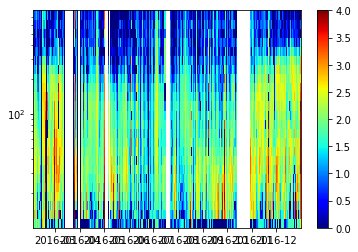

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.pcolor(data.index, data.columns, np.log10(abs(data.values[::1, ::1].T)+1e-6) , cmap='jet')
plt.colorbar()
plt.clim(0, 4)

plt.yscale('log')
plt.show()

In [45]:
data.dropna()#.head()

,10.004326,12.008173,14.413181,17.299594,20.763803,24.921526,29.911103,35.899205,43.085944,51.714942,...,154.511810,185.440310,222.572140,267.137350,320.576050,384.806340,461.948390,554.557330,665.728170,799.178630
datetime,,,,,,,,,,,,,,,,,,,,,
2016-02-02 00:00:00,26786.189500,16754.82850,12936.61650,9974.15095,8185.58920,6378.26915,5217.73160,4272.42610,3580.657300,2922.99865,...,1848.09110,900.204395,0.00000,0.000000,0.000000,96.291460,477.619535,2061.284500,2695.662700,3131.496900
2016-02-02 00:10:00,27116.588000,16301.83600,13266.95200,9785.67850,8088.26730,6341.93790,5312.20890,4174.05820,3653.034800,3042.37430,...,1974.14040,937.453480,0.00000,0.000000,0.000000,53.955001,431.735400,2114.220200,2949.241400,3115.186700
2016-02-02 00:20:00,30307.030000,19704.10250,15232.15750,11467.49950,9150.24550,7171.84380,5975.99435,5010.29865,4281.022300,3592.75980,...,2241.14685,1023.262050,0.00000,0.000000,0.000000,77.568011,632.630335,2461.022650,3256.432700,3494.479300
2016-02-02 00:30:00,32096.298500,20057.89000,15170.99900,11870.38450,9156.46920,7449.57435,6169.61595,4954.63760,4203.932350,3603.07255,...,2302.40370,949.130885,0.00000,0.000000,0.000000,117.865956,584.493660,2528.869250,3310.813150,3703.782850
2016-02-02 00:40:00,33434.570000,22267.85250,16554.67950,12657.68300,10079.19950,7979.51630,6630.49885,5218.97385,4514.552250,3882.29810,...,2390.41545,1083.254495,0.00000,0.000000,0.000000,65.613499,654.166590,2567.651400,3526.117950,3778.226550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:10:00,0.000000,1681.75480,957.38136,1239.75010,1821.33470,2471.66210,2788.50210,2545.98310,8523.275300,1067.64800,...,4794.74140,1465.766900,1227.59130,361.910250,78.114088,0.000000,0.000000,16.862526,20.389453,33.256082
2016-12-31 23:20:00,923.025135,1918.81515,1065.69955,1262.96050,2020.82930,1875.75400,3382.12680,2845.58815,1095.360665,2775.56983,...,1525.07324,915.688692,755.85358,890.295035,539.737110,207.174440,52.047520,28.141186,22.948844,22.430796
2016-12-31 23:30:00,531.572400,2326.87125,1663.12965,1479.00780,1970.49595,2025.14555,1822.58195,1391.09410,1130.830180,2404.80165,...,1153.67983,1083.863950,266.44320,1120.128915,222.322740,61.320930,0.000000,21.677773,3.120511,35.325902


In [29]:
print(f"Data shape: {data.shape}\n") 
print(f"Columns: \n{data.columns}")

Data shape: (48096, 25)

Columns: 
Float64Index([10.004325999999999,          12.008173,          14.413181,
                       17.299594,          20.763803,          24.921526,
              29.911102999999997,          35.899205, 43.085944000000005,
                       51.714942, 62.063635000000005,  74.48226600000001,
               89.39141000000001,          107.27887,          128.74585,
                       154.51181,          185.44031,          222.57214,
                       267.13735,          320.57605,          384.80634,
                       461.94839,          554.55733,  665.7281700000001,
                       799.17863],
             dtype='float64')


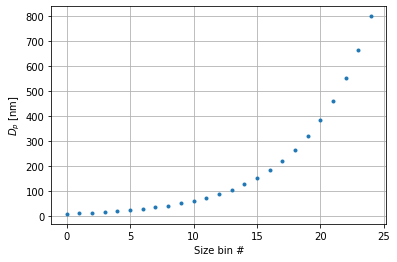

Number of bins: (25,)


In [24]:
plt.plot(data.columns, '.')

plt.xlabel('Size bin #')
plt.ylabel('$D_p$ [nm]')
# plt.yscale('log')
plt.grid()
plt.show()

print(f"Number of bins: {data.columns.shape}") 

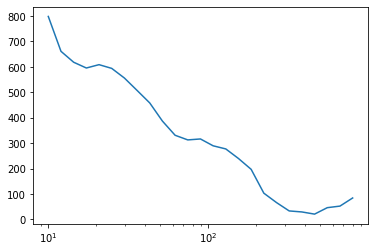

In [55]:
data.mean(axis=0).plot()
plt.xscale('log')

## Flags description

| Flag | Description                                 |
| ---- | ------------------------------------------- |
| 0    | Good data                                   |
| 1    | Wind from polluted sector (0-90 degrees)    |
| 2    | Wind speed too low, < 1 m/s                 |
| 3    | Suspect instrument problem                  |
| 4    | Suspect local pollution                     |
| 999  | Instrument prolem or local pollution (Note) | 


Note:  years 2015, 2017 data, these were not separated

In [58]:
data

,10.004326,12.008173,14.413181,17.299594,20.763803,24.921526,29.911103,35.899205,43.085944,51.714942,...,154.511810,185.440310,222.572140,267.137350,320.576050,384.806340,461.948390,554.557330,665.728170,799.178630
datetime,,,,,,,,,,,,,,,,,,,,,
2016-02-02 00:02:31.977600,25853.73100,15739.2550,12770.0870,10144.2010,8067.0735,6351.3737,5241.0107,4210.9736,3470.81190,2911.4082,...,1903.38800,924.94047,0.00000,0.00000,0.000000,101.688440,474.656470,2061.204200,2761.991000,3186.366300
2016-02-02 00:08:28.032000,27718.64800,17770.4020,13103.1460,9804.1009,8304.1049,6405.1646,5194.4525,4333.8786,3690.50270,2934.5891,...,1792.79420,875.46832,0.00000,0.00000,0.000000,90.894481,480.582600,2061.364800,2629.334400,3076.627500
2016-02-02 00:14:24.000000,27116.58800,16301.8360,13266.9520,9785.6785,8088.2673,6341.9379,5312.2089,4174.0582,3653.03480,3042.3743,...,1974.14040,937.45348,0.00000,0.00000,0.000000,53.955001,431.735400,2114.220200,2949.241400,3115.186700
2016-02-02 00:20:19.968000,28945.92900,18810.7880,14499.2710,11074.1410,8688.0764,6897.2599,5704.6716,4764.6921,4095.02100,3427.9919,...,2261.43160,1011.36720,0.00000,0.00000,0.000000,103.353250,552.757170,2548.495300,3279.661000,3541.648800
2016-02-02 00:26:16.022400,31668.13100,20597.4170,15965.0440,11860.8580,9612.4146,7446.4277,6247.3171,5255.9052,4467.02360,3757.5277,...,2220.86210,1035.15690,0.00000,0.00000,0.000000,51.782773,712.503500,2373.550000,3233.204400,3447.309800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:32:19.392000,1063.14480,2287.8114,1397.1738,1235.5252,2173.7709,2298.5620,1690.7413,937.2511,1687.21500,3277.4866,...,927.81726,0.00000,0.00000,2012.45500,170.199250,0.000000,0.000000,43.355546,6.241023,70.651804
2016-12-31 23:38:16.224000,0.00000,2365.9311,1929.0855,1722.4904,1767.2210,1751.7291,1954.4226,1844.9371,574.44536,1532.1167,...,1379.54240,2167.72790,532.88640,227.80283,274.446230,122.641860,0.000000,0.000000,0.000000,0.000000
2016-12-31 23:44:13.920000,0.00000,2163.0329,2060.3426,3109.7417,2302.6413,2136.8143,2202.4007,1937.0040,4297.47780,3140.7027,...,11328.02600,5446.87360,1663.58760,425.14640,54.604987,51.767415,23.532277,17.038233,16.462388,4.162471
